<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Clasificación de textos con CNN y RNN<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-14</small></i></div>
                                                  

***

## Introducción

En NLP una tarea muy típica es la de clasificación tde textos. En ella, se clasifica un texto determinado en función de su significado. Suele usarse, por ejemplo, para el problema del análisis de sentimiento.

Se trata de un problema de los que se denominan _many-to-one_, es decir, aquel donde el tamaño de secuencia de entrada es $T_X \ge 1$, pero el tamaño de secuencia de salida es $T_Y = 1$.

## Objetivos

Vamos a hacer un ejercicio de clasificación de comentarios tóxicos a partir del dataset de Kaggle presentado en el ejercicio anterior. Para ello usaremos, en un principio, redes de convolución. Posteriormente veremos cómo el cambio a redes recurrentes es inmediato y no requiere apenas cambio en los modelos.

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook.

In [4]:
import os.path
import requests
from shutil import unpack_archive

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [5]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Carga de _embedding_ preentrenado

Descargamos el dataset de [GloVe](https://nlp.stanford.edu/projects/glove/), concretamente el que se encuentra en http://nlp.stanford.edu/data/glove.6B.zip

In [6]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'tmp/glove.6B.zip'
GLOVE_DIR = 'tmp/'

if not os.path.isdir(GLOVE_DIR):
    os.makedirs(GLOVE_DIR)

# Descargamos el dataset comprimido de GloVe (si no lo tenemos ya)
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Lo descomprimimos en el directorio 'glove'
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, GLOVE_DIR)
print('OK')

Unpacking ...OK


Configuramos los parámetros para el sistema

In [7]:
# Cuántas dimensiones tienen nuestros word vectors (50, 100, 200 o 300)
EMBEDDING_DIM = 50
# El tamaño máximo de nuestro vocabulario (se escogerán las más frecuentes)
MAX_VOCAB_SIZE = 10000
# El tamaño de la frase más larga con la que alimentar el modelo
MAX_SEQUENCE_LENGTH = 50

Cargamos el _embedding_ de dimensión especificada en la configuración

In [8]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 50-d embedding... done (400000 word vectors loaded)


Y ahora cargamos los datos de entrenamiento

In [9]:
print('Loading toxic comments training dataset... ', end='')
df = pd.read_csv('Datasets/Toxic/train.csv')
sentences = df['comment_text'].fillna('DUMMY_VALUE').values
targets = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values[:,0]
print(f'done ({len(sentences)} comments loaded)')
print(f'Biggest comment length:  {max(len(s) for s in sentences)}')
print(f'Smallest comment length: {min(len(s) for s in sentences)}')
print(f'Avg. comment length:     {np.mean([len(s) for s in sentences])}')
print(f'Median comment length:   {sorted(len(s) for s in sentences)[len(sentences) // 2]}')
print('-' * 20)
print(f'Example comment: {sentences[9]}')
print(f'Example targets: {targets[9]}')

Loading toxic comments training dataset... done (159571 comments loaded)
Biggest comment length:  5000
Smallest comment length: 6
Avg. comment length:     394.0732213246768
Median comment length:   205
--------------------
Example comment: alignment on this subject and which are contrary to those of DuLithgow
Example targets: 0


Convertimos las frases en enteros

In [13]:
tokenizer =   tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences =   tokenizer.texts_to_sequences(sentences)
word_index =  tokenizer.word_index

print(f'Biggest index: {max(max(seq) for seq in sequences if len(seq) > 0)}')
print(f'Unique tokens: {len(word_index)}')
print('-' * 20)
print(f'Example comment: {sentences[9]}: {sequences[9]}')

Biggest index: 9999
Unique tokens: 210337
--------------------
Example comment: alignment on this subject and which are contrary to those of DuLithgow: [15, 13, 242, 4, 53, 19, 1815, 2, 142, 3]


Creamos las secuencias del tamaño especificado, haciendo _padding_ donde corresponda.

In [12]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    value=0,
    maxlen=MAX_SEQUENCE_LENGTH
)
print(f'Data tensor shape: {data.shape}')
data[0]

Data tensor shape: (159571, 50)


array([   0,    0,    0,    0,    0,    0,  688,   75,    1,  126,  130,
        177,   29,  672, 4511, 1116,   86,  331,   51, 2278,   50, 6864,
         15,   60, 2756,  148,    7, 2937,   34,  117, 1221, 2825,    4,
         45,   59,  244,    1,  365,   31,    1,   38,   27,  143,   73,
       3462,   89, 3085, 4583, 2273,  985])

Creamos una capa de embedding a partir de los datos de GloVe. Si resulta que la palabra no está dentro de GloVe, dicha palabra se quedará como un vector de ceros

In [14]:
print('Loading embedding with GloVe vectors... ', end='')
# Cargamos sólo las palabras elegidas de nuestro conjunto de datos
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Creamos la capa de embedding
embedding_layer = tf.keras.layers.Embedding(
  input_dim=num_words,
  output_dim=EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False,
)
print('done')

Loading embedding with GloVe vectors... done


## Clasificación usando CNN

Haremos una primera aproximación al problema usando redes convolucionales. En este caso, nuestras frases serán representadas por "imágenes" de una única fila, con tantas columnas como a longitud de la secuencia especificada y tantos canales como dimensión tiene cada valabra de la secuencia.

In [15]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['binary_accuracy'],
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            500000    
                                                                 
 conv1d (Conv1D)             (None, 48, 16)            2416      
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 8)                 6152      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 508,577
Trainable params: 8,577
Non-trainable p

Entrenamos el modelo (10 epochs con separación de conjunto de validación del 10%)

In [16]:
history = model.fit(data, targets, epochs=10, validation_split=0.1, batch_size=4096)

Epoch 1/10
36/36 [==============================] - 2s 48ms/step - loss: 0.3778 - binary_accuracy: 0.8707 - val_loss: 0.2934 - val_binary_accuracy: 0.9033
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.2747 - binary_accuracy: 0.9042 - val_loss: 0.2628 - val_binary_accuracy: 0.9033
Epoch 3/10
36/36 [==============================] - 2s 42ms/step - loss: 0.2553 - binary_accuracy: 0.9042 - val_loss: 0.2512 - val_binary_accuracy: 0.9033
Epoch 4/10
36/36 [==============================] - 2s 42ms/step - loss: 0.2464 - binary_accuracy: 0.9043 - val_loss: 0.2448 - val_binary_accuracy: 0.9033
Epoch 5/10
36/36 [==============================] - 2s 43ms/step - loss: 0.2407 - binary_accuracy: 0.9043 - val_loss: 0.2405 - val_binary_accuracy: 0.9033
Epoch 6/10
36/36 [==============================] - 2s 42ms/step - loss: 0.2350 - binary_accuracy: 0.9044 - val_loss: 0.2266 - val_binary_accuracy: 0.9041
Epoch 7/10
36/36 [==============================] - 2s 44ms/step - los

Veamos qué tal ha ido el entrenamiento:

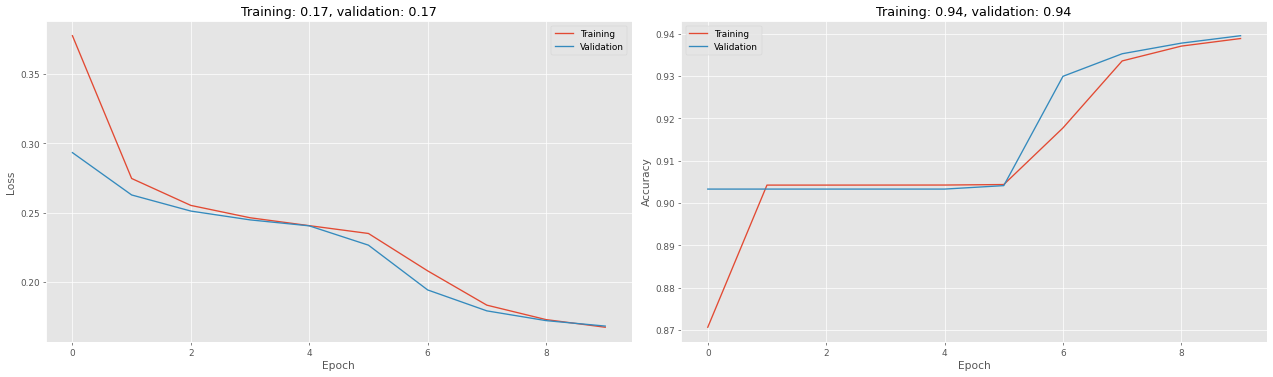

In [17]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {history.history["loss"][-1]:.2f}, validation: {history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training')
plt.plot(history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {history.history["binary_accuracy"][-1]:.2f}, validation: {history.history["val_binary_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

Vaya, parece que bastante bien. Veamos ahora qué tal lo hace con el conjunto de test:

In [18]:
df = pd.read_csv('Datasets/Toxic/test.csv')
test_sentences = df['comment_text'].fillna('DUMMY_VALUE').values
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences,
    value=0,
    padding='post',
    maxlen=MAX_SEQUENCE_LENGTH
)
df = pd.read_csv('Datasets/Toxic/test_labels.csv')
test_targets = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values[:,0]

r = model.evaluate(test_data, test_targets)
print(f'Results (loss, acc): {r}')

4787/4787 [==============================] - 4s 877us/step - loss: -0.8615 - binary_accuracy: 0.3828
Results (loss, acc): [-0.8615180253982544, 0.38279882073402405]


## Clasificación usando RNN

Ahora haremos el mismo ejercicio, pero usando un modelo basado en redes neuronales recurrentes. Para ello partiremos de un nuevo modelo.

In [19]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = tf.keras.layers.GRU(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['binary_accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            500000    
                                                                 
 gru (GRU)                   (None, 128)               69120     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 569,249
Trainable params: 69,249
Non-trainable params: 500,000
_________________________________________________________________


Lo entrenamos

In [20]:
history = model.fit(data, targets, epochs=10, validation_split=0.1, batch_size=4092)

Epoch 1/10
36/36 [==============================] - 42s 1s/step - loss: 0.3497 - binary_accuracy: 0.8625 - val_loss: 0.2611 - val_binary_accuracy: 0.9160
Epoch 2/10
36/36 [==============================] - 36s 1s/step - loss: 0.2339 - binary_accuracy: 0.9210 - val_loss: 0.1985 - val_binary_accuracy: 0.9315
Epoch 3/10
36/36 [==============================] - 40s 1s/step - loss: 0.1770 - binary_accuracy: 0.9361 - val_loss: 0.1619 - val_binary_accuracy: 0.9434
Epoch 4/10
36/36 [==============================] - 38s 1s/step - loss: 0.1577 - binary_accuracy: 0.9435 - val_loss: 0.1576 - val_binary_accuracy: 0.9461
Epoch 5/10
36/36 [==============================] - 38s 1s/step - loss: 0.1517 - binary_accuracy: 0.9458 - val_loss: 0.1486 - val_binary_accuracy: 0.9498
Epoch 6/10
36/36 [==============================] - 42s 1s/step - loss: 0.1467 - binary_accuracy: 0.9481 - val_loss: 0.1443 - val_binary_accuracy: 0.9502
Epoch 7/10
36/36 [==============================] - 36s 1s/step - loss: 0.14

Veamos como ha ido

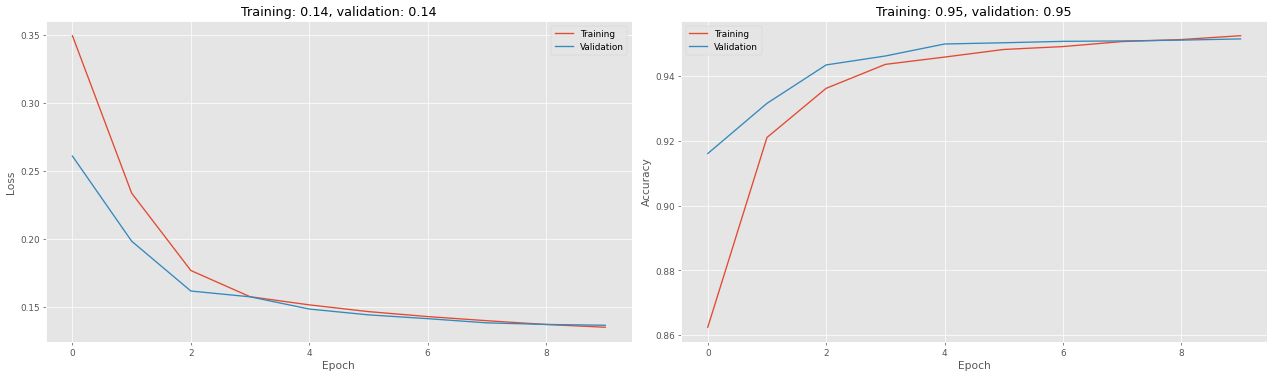

In [21]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {history.history["loss"][-1]:.2f}, validation: {history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training')
plt.plot(history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {history.history["binary_accuracy"][-1]:.2f}, validation: {history.history["val_binary_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

¿Y el desempeño en test?

In [22]:
df = pd.read_csv('Datasets/Toxic/test.csv')
test_sentences = df['comment_text'].fillna('DUMMY_VALUE').values
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences,
    value=0,
    padding='post',
    maxlen=MAX_SEQUENCE_LENGTH
)
df = pd.read_csv('Datasets/Toxic/test_labels.csv')
test_targets = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values[:,0]

r = model.evaluate(test_data, test_targets)
print(f'Results (loss, acc): {r}')

4787/4787 [==============================] - 34s 7ms/step - loss: -1.3561 - binary_accuracy: 0.3828
Results (loss, acc): [-1.3560923337936401, 0.38280534744262695]


# Clasificación de textos con RNN bidireccionales

Ahora haremos el mismo ejercicio, pero usando un modelo basado en redes neuronales recurrentes bidireccionales. Para ello partiremos de un nuevo modelo.

In [23]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(input_, output)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            500000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              138240    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 638,497
Trainable params: 138,497
Non-trainable params: 500,000
_______________________________________________

Un modelo bastante más complejo. Vamos a entrenarlo:

In [24]:
history = model.fit(data, targets, epochs=10, validation_split=0.1, batch_size=4096)

Epoch 1/10
36/36 [==============================] - 68s 2s/step - loss: 0.0000e+00 - accuracy: 0.8986 - val_loss: 0.0000e+00 - val_accuracy: 0.9032
Epoch 2/10
36/36 [==============================] - 70s 2s/step - loss: 0.0000e+00 - accuracy: 0.9042 - val_loss: 0.0000e+00 - val_accuracy: 0.9032
Epoch 3/10
36/36 [==============================] - 68s 2s/step - loss: 0.0000e+00 - accuracy: 0.9042 - val_loss: 0.0000e+00 - val_accuracy: 0.9032
Epoch 4/10
36/36 [==============================] - 67s 2s/step - loss: 0.0000e+00 - accuracy: 0.9042 - val_loss: 0.0000e+00 - val_accuracy: 0.9032
Epoch 5/10
36/36 [==============================] - 69s 2s/step - loss: 0.0000e+00 - accuracy: 0.9042 - val_loss: 0.0000e+00 - val_accuracy: 0.9032
Epoch 6/10
36/36 [==============================] - 69s 2s/step - loss: 0.0000e+00 - accuracy: 0.9042 - val_loss: 0.0000e+00 - val_accuracy: 0.9032
Epoch 7/10
36/36 [==============================] - 70s 2s/step - loss: 0.0000e+00 - accuracy: 0.9042 - val_loss

Y ahora veamos cómo ha evolucionado el entrenamiento

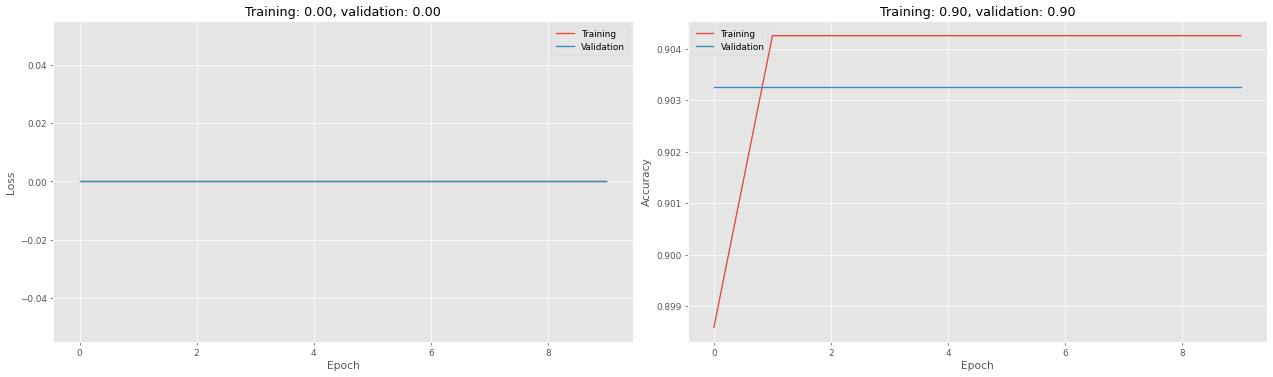

In [25]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {history.history["loss"][-1]:.2f}, validation: {history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {history.history["accuracy"][-1]:.2f}, validation: {history.history["val_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

Veamos el desempeño en test:

In [26]:
df = pd.read_csv('Datasets/Toxic/test.csv')
test_sentences = df['comment_text'].fillna('DUMMY_VALUE').values
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences,
    value=0,
    padding='post',
    maxlen=MAX_SEQUENCE_LENGTH
)
df = pd.read_csv('Datasets/Toxic/test_labels.csv')
test_targets = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values[:,0]

r = model.evaluate(test_data, test_targets)
print(f'Results (loss, acc): {r}')

4787/4787 [==============================] - 89s 19ms/step - loss: 0.0000e+00 - accuracy: 0.3779
Results (loss, acc): [0.0, 0.3779478073120117]


## Conclusiones

Hemos implementado y comparado tres técnicas de aprendizaje profundo para la tarea de clasificación de textos: redes de convolución, redes recurrentes y redes recurrentes bidireccionales. Las redes recurrentes bidireccionales suelen ser idóneas para estos casos ya que son capaces de entender en contexto de las palabras **dentro** de la frase, tanto por las palabras antecedentes como las consecuentes.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>